In [1]:
%cd ..

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time

from sklearn.metrics import confusion_matrix, classification_report

# from opt.svm import SVC
from opt.utils.data_splitter import split4ovr, split4ovo, label2binary
from opt.utils.metrics import measure_performance

# Fix random seed
np.random.seed(0)

### Dataset

In [3]:
# Load data
# data = np.load('data/dummy_binary/filtered_mnist.npz')
data = np.load('data/filtered_mnist.npz')
x_train = data['a']
y_train = data['b']
x_test  = data['c']
y_test  = data['d']
print("Number of training samples:       ", len(y_train))
print("Distribution of training samples: ", Counter(y_train))
print("Number of test samples:           ", len(y_test))
print("Distribution of training samples: ", Counter(y_test))

Number of training samples:        1200
Distribution of training samples:  Counter({1: 300, 9: 300, 0: 300, 6: 300})
Number of test samples:            800
Distribution of training samples:  Counter({0: 200, 9: 200, 1: 200, 6: 200})


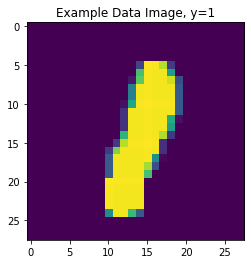

In [4]:
# Visualise data
imx, imy = (28,28)
visual = np.reshape(x_train[0], (imx,imy))
plt.title("Example Data Image, y="+str(int(y_train[0])))
plt.imshow(visual, vmin=0, vmax=1)

### SVM Model

In [5]:
import numpy as np
from scipy import stats
import cvxopt
import time

from opt.algos.interior_point import barrier_method
from opt.algos.smo import smo
from opt.utils.kernels import polynomial_kernel_matrix, gaussian_kernel_matrix

class SVC:
    """
    Multiclass soft-margin kernelised SVM.  
    """
    def __init__(self, C=1.0, kernel="gauss", param=0.5, decision_function_shape="ovo", 
                 loss_fn='L1', opt_algo="smo"):
        """
        Arguments:
        ----------
        C : `float`
            Regularization parameter. The strength of the regularization is 
            inversely proportional to C. Must be strictly positive. 
            The penalty is a squared l2 penalty.
        kernel : `str`
            The Kernel to use. {'poly', 'gauss'}.
        param : `float`
            Parameter of the kernel chosen, 
            i.e. the degree if polynomial or the gamma is gaussian. {'scale', 'auto'}
        decision_function_shape : `NoneType` or `str`
            The method for multiclass classification. {'ovo','ovr'}.
        loss_fn : `str`
            The loss function for the optimisation problem. {'L1','L2'}.
        opt_algo : `str`
            The optimisation method to use. {'barrier', 'smo'}.
        """         
        self.C = float(C)
        self.kernel = kernel
        self.param  = param
        self.decision_function_shape = decision_function_shape
        self.loss_fn  = loss_fn
        self.opt_algo = opt_algo
        self.classifiers = dict()
        self._params = dict()
        
    def fit(self, X, y, **kwargs):
        """
        Function to train the SVM.
        
        Parameters:
        -----------
        X : `dict` of `numpy.ndarray` or `numpy.ndarray`
             if self.decision_function_shape="ovo":
                 Dictionary of all the kchoose2 datasets for the classifiers.
                (nData, nDim) matrix of data.
             if self.decision_function_shape="ovr"
                 (nData, nDim) matrix of data.
        y : `dict` of `numpy.ndarray`
             if self.decision_function_shape="ovo":
                 Dictionary of labels for the kchoose2 classifiers.
                (nData,) matrix of corresponding labels. Each element is in the set {-1,+1}.
             if self.decision_function_shape="ovr"
                 Dictionary of labels for the k classifiers.
                (nData,) matrix of corresponding labels. Each element is in the set {-1,+1}.
        """
        self.opt_info = dict()
        start_time = time.time()
        if self.decision_function_shape == "ovo":
            for ClassVsClass, labels in y.items():
                data = X[ClassVsClass]
                # Get kernel matrix
                if self.kernel == "poly":
                    self._params[ClassVsClass] = self.param
                    kernel_matrix = polynomial_kernel_matrix(data, data, 0, self._params[ClassVsClass])
                elif self.kernel == "gauss":
                    if self.param == "scale":
                        self._params[ClassVsClass] = 1/(data.shape[1]*data.var())
                    elif self.param == "auto":
                        self._params[ClassVsClass] = 1/data.shape[1]
                    else:
                        self._params[ClassVsClass] = self.param 
                    kernel_matrix = gaussian_kernel_matrix(data, data, self._params[ClassVsClass])
                # Initialise binary classifier
                self.classifiers[ClassVsClass] = SVM(self.C, self.kernel, self._params[ClassVsClass])
                # Fit binary classifier
                self.opt_info[ClassVsClass] = self.classifiers[ClassVsClass].fit(data, labels, kernel_matrix, 
                                                                                 self.loss_fn, self.opt_algo,
                                                                                 **kwargs)                   
                
        elif self.decision_function_shape == "ovr":
            # Get kernel matrix
            if self.kernel == "poly":
                self._params[ClassVsR] = self.param                                    
                kernel_matrix = polynomial_kernel_matrix(X, X, 0, self._params[ClassVsR])
            elif self.kernel == "gauss":
                if self.param == "scale":
                    self._params[ClassVsR] = 1/(data.shape[1]*data.var())
                elif self.param == "auto":
                    self._params[ClassVsR] = 1/data.shape[1]
                else:
                    self._params[ClassVsR] = self.param
                kernel_matrix = gaussian_kernel_matrix(X, X, self._params[ClassVsR]) 
            for ClassVsR, labels in y.items():
                # Initialise binary classifier
                self.classifiers[ClassVsR] = SVM(self.C, self.kernel, self._params[ClassVsR])
                # Fit binary classifier
                self.opt_info[ClassVsR] = self.classifiers[ClassVsR].fit(X, labels, kernel_matrix, 
                                                                         self.loss_fn, self.opt_algo, 
                                                                         **kwargs) 
        self.time_taken = round(time.time() - start_time, 6)
        
    def predict(self, X):
        """
        Predict on test set.
        
        Parameters:
        -----------
        X : `numpy.ndarray`
            (nData, nDim) matrix of test data. Each row corresponds to a data point.  
            
        Returns:
        --------
        yhats : `numpy.ndarray`
            (nData,) List of predictions on the test data.
        """
        nClassifiers = len(self.classifiers)
        # Create matrix (nClassifiers, nTestData) 
        predictions = np.zeros((nClassifiers, X.shape[0]))
        
        if self.decision_function_shape == "ovo":
            for i, (ClassVsClass, svm) in enumerate(self.classifiers.items()):
                yhats = np.sign(svm.predict(X))
                # Convert predictions labels to digits.
                predictions[i,:] = self.convert_labels2digits(yhats, int(ClassVsClass[0]), int(ClassVsClass[-1]))
            # Return the mode label for each test data point.
            # If there is more than one such value, only the smallest is returned.
            return np.squeeze(stats.mode(predictions, axis=0)[0])
       
        elif self.decision_function_shape == "ovr":
            index2class = dict()
            for i, (ClassVsR, svm) in enumerate(self.classifiers.items()):
                predictions[i,:] = svm.predict(X)
                index2class[i] = int(ClassVsR[0])
            # Return the label with the highest value.
            return np.array([index2class[i] for i in np.argmax(predictions, axis=0)])
        
    @staticmethod
    def convert_labels2digits(yhats, pos_label, neg_label):
        """
        Functions that maps +1 to the positive class label 
        and -1 to the negative class label.
        
        Parameters:
        -----------
        yhats : `numpy.ndarray`
            The predictions from the classifier.
        pos_label : `int`
            The positive class label.
        neg_label : `int`
            The negative class label.
            
        Returns:
        --------
        digits : `numpy.ndarray`
            The predicitions mapped to the class labels +1 -> pos_labels, -1 -> neg_labels.
        """
        return np.where(yhats==1, pos_label, neg_label)        

In [6]:
class SVM:
    """
    Soft-margin kernalised SVM base class
    """
    def __init__(self, C=1.0, kernel='gauss', param=0.5):
        """
        Arguments:
        ----------
        C : `float`
            Regularization parameter. The strength of the regularization is 
            inversely proportional to C. Must be strictly positive. 
            The penalty is a squared l2 penalty.  
        kernel : `str`
            The Kernel to use. {'poly', 'gauss'}.      
        param : `float`
            Parameter of the kernel chosen, 
            i.e. the degree if polynomial or the gamma is gaussian.             
        """        
        self.C = float(C)
        self.kernel = kernel
        self.param  = param
        
    def fit(self, X, y, kernel_matrix, loss_fn, opt_algo, **kwargs):
        """
        Function to fit SVM.
        
        min 0.5x^TPx + q^Tx
        s.t. Gx <= h
             Ax = b        
        
        Parameters:
        -----------
        X : `numpy.ndarray`
            (nData, nDim) matrix of data. Each row corresponds to a data point.
        y : `numpy.ndarray`
            (nData,) matrix of corresponding labels. Each element is in the set {-1,+1}.
        kernel_matrix : `numpy.ndarray`
            (nData, nData) Kernel matrix of training data.  
        loss_fn : `str`
            The loss function for the optimisation problem. {'L1','L2'}.            
        opt_algo : `str`
            The optimisation method to use. {'barrier', 'smo'}.
            
        Returns:
        --------
        opt_info : `dict`
            Information about optimisation.            
        """ 
        # Convert data to floats
        X = X.astype(float)
        y = y[:,None].astype(float)
        n, d = X.shape
        
        # Parameters of optimisation problem
        if loss_fn == 'L1':
            P = y@y.T*kernel_matrix
            q = -np.ones((n,1))
            G = np.vstack((-np.eye(n), 
                            np.eye(n)))
            h = np.vstack((np.zeros((n,1)), 
                           self.C*np.ones((n,1))))
            A = y.T
            b = np.zeros(1)    
        elif loss_fn == 'L2':
            P = y@y.T*(kernel_matrix + 1/self.C * np.eye(n))
            q = -np.ones((n,1))
            G = -np.eye(n)
            h = np.zeros((n,1))
            A = y.T
            b = np.zeros(1)
        
        # Optimisation        
        if opt_algo == "barrier":      
            # TODO: Get feasible starting point
            x0  = feasible_starting_point(y, self.C)  
            # Solve QP problem
            sol = barrier_method(P, q, G, h, A, b, x0, **kwargs) 
            # Get lambdas (the Lagrange multipliers)
            lambdas = sol['x']
            
        elif opt_algo == "smo":     
            # Solve QP problem
            sol = smo(y, kernel_matrix, self.C, loss_fn, **kwargs) 
            # Get lambdas (the Lagrange multipliers)
            lambdas = sol['x']
        
        elif opt_algo == "cvxopt":
            P = cvxopt.matrix(P)
            q = cvxopt.matrix(q)
            G = cvxopt.matrix(G)
            h = cvxopt.matrix(h)
            A = cvxopt.matrix(A)
            b = cvxopt.matrix(b)         
            # Setting solver parameters
            cvxopt.solvers.options['show_progress'] = False   
            # Solve QP problem
            sol = cvxopt.solvers.qp(P, q, G, h, A, b)
            # Get lambdas (the Lagrange multipliers)
            lambdas = np.array(sol['x'])
              
        # Support vectors have non-zero lambdas
        if loss_fn == 'L1':
            SV  = np.logical_and(lambdas>1e-5, lambdas<=self.C).flatten() # Margin and non-margin support vectors
            MSV = np.logical_and(lambdas>1e-5, lambdas<self.C).flatten()  # Margin support vectors
        elif loss_fn == 'L2':
            SV  = (lambdas>1e-5).flatten()
        self.lambdas = lambdas[SV]
        self.sv   = X[SV]
        self.sv_y = y[SV]  
        sol["nSVs"] = sum(SV) 
        # Compute bias term
        if loss_fn == "L1":
            self.bias = np.mean(y[SV] - ((lambdas[SV]*y[SV]).T@kernel_matrix[SV][:,SV]).T) 
        elif loss_fn == "L2":
            self.bias = np.mean(y[SV] - ((lambdas[SV]*y[SV]).T@(kernel_matrix[SV][:,SV]+(1/self.C)*np.eye(sol["nSVs"]))).T)
        return sol

    def predict(self, X):
        """
        Predict on test set.
        
        Parameters:
        -----------
        X : `numpy.ndarray`
            (nData, nDim) matrix of test data. Each row corresponds to a data point.              
            
        Returns:
        --------
        yhats : `numpy.ndarray`
            (nData,) List of predictions on the test data, not corresponding to labels {-1,+1}
            Need to take np.sign() after.
        """               
        # Get kernel matrix between support vectors and test data
        if self.kernel == "poly":
            kernel_matrix = polynomial_kernel_matrix(self.sv, X, 0, self.param)
        elif self.kernel == "gauss":
            kernel_matrix = gaussian_kernel_matrix(self.sv, X, self.param) 
        return np.squeeze((self.lambdas*self.sv_y).T@kernel_matrix + self.bias)

In [7]:
def feasible_starting_point(y, C):
    """
    Calculate feasible starting point for 
    Barrier method.
    
    TODO: Understand and write a better one
    """
    total_num = len(y)
    pos = np.sum(y==1)
    pos_frac = pos / (total_num-pos)
    x0 = np.zeros((total_num,1))
    for i in range(total_num):
        if y[i]==1:
            x0[i] = C*(1-pos/total_num)
        else:
            x0[i] = C*pos_frac*(1-pos/total_num)
    return x0

## Main

#### Scikit-Learn SVM

In [8]:
from sklearn.svm import SVC as cheatSVM
cheat_svm = cheatSVM(C=1.0,
                     kernel='rbf',
                     decision_function_shape='ovo') 
cheat_svm.fit(x_train, y_train)
cheat_pred = cheat_svm.predict(x_test)

In [9]:
measure_performance(y_test, cheat_pred, average="macro")

,Accuracy,Precision,Recall,F1,MCC
0,0.9912,0.9913,0.9912,0.9913,0.9883


#### My SVM

Problems:
1. For Barrier, the point $\mathbf{x}_k$ after Newton is not feasible, thus why the log barrier function spits out a nan
2. Method for feasible starting point for barrier method
3. L2 version for smo

In [10]:
# OVO data
x_train_ovo, y_train_ovo = split4ovo(x_train, y_train)
# OVR data
y_train_ovr = split4ovr(y_train)

In [11]:
# Parameters
# Initialise SVM
svm = SVC(C=1.0, 
          kernel="gauss", 
          param='scale', 
          decision_function_shape="ovo",
          loss_fn='L2',
          opt_algo="smo")

# Train OVR: svm.fit(x_train, y_train_ovr)

# svm.fit(x_train_ovo, y_train_ovo,
#         t=1, 
#         mu=1.1, 
#         tol=1e-6, 
#         max_iter=100,
#         tolNewton=1e-12,
#         maxIterNewton=100)

svm.fit(x_train_ovo, y_train_ovo,
        tol=1e-3, 
        max_iter=5)

# Test
yhat = svm.predict(x_test)
measure_performance(y_test, yhat, average="macro")

SMO method iteration:  0
SMO method iteration:  1
SMO method iteration:  2
SMO method iteration:  3
SMO method iteration:  4
SMO method iteration:  0
SMO method iteration:  1
SMO method iteration:  2
SMO method iteration:  3
SMO method iteration:  4
SMO method iteration:  0
SMO method iteration:  1
SMO method iteration:  2
SMO method iteration:  3
SMO method iteration:  4
SMO method iteration:  0
SMO method iteration:  1
SMO method iteration:  2
SMO method iteration:  3
SMO method iteration:  4
SMO method iteration:  0
SMO method iteration:  1
SMO method iteration:  2
SMO method iteration:  3
SMO method iteration:  4
SMO method iteration:  0
SMO method iteration:  1
SMO method iteration:  2
SMO method iteration:  3
SMO method iteration:  4


,Accuracy,Precision,Recall,F1,MCC
0,0.9838,0.9838,0.9838,0.9838,0.9783


#### Convergence Plots

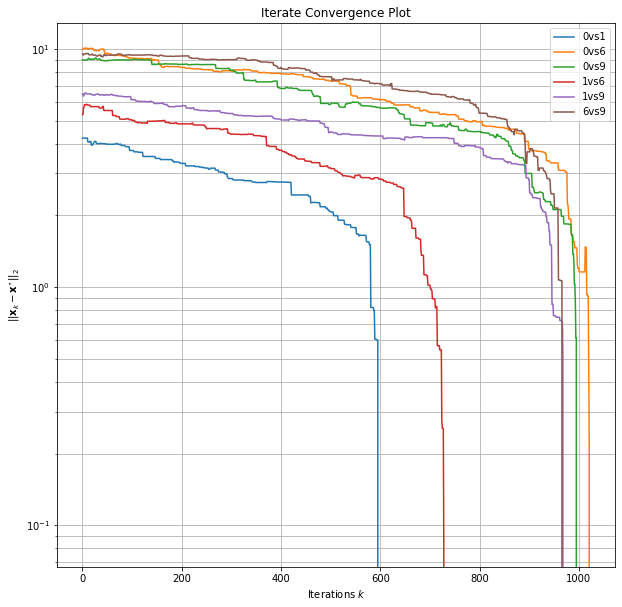

In [12]:
plt.figure(figsize=(10,10))
for ClassVsClass, info in svm.opt_info.items():
    plt.plot(np.linalg.norm(np.array(info['iterates'])-info['x'], axis=1), label=ClassVsClass)
plt.title("Iterate Convergence Plot")
plt.ylabel("$|| \mathbf{x}_k-\mathbf{x}^{\star} ||_2$")
plt.xlabel("Iterations $k$")
plt.yscale("log")
plt.legend()
plt.grid(which='both', axis='both')
plt.show()

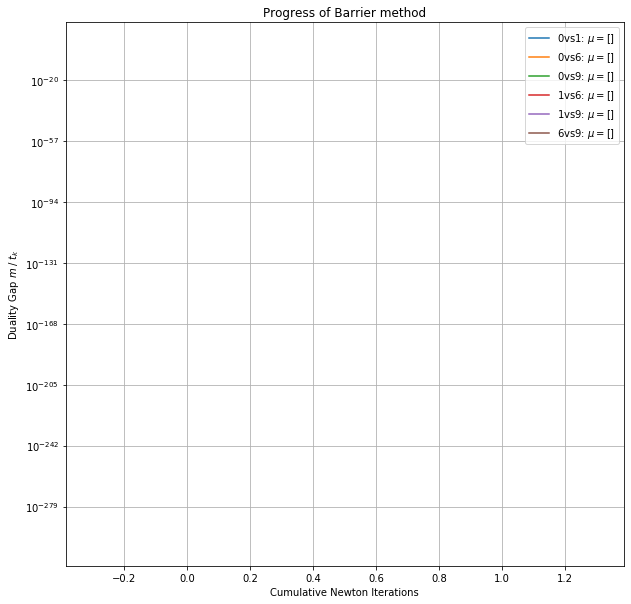

In [13]:
plt.figure(figsize=(10,10))
for ClassVsClass, info in svm.opt_info.items():
    plt.step(np.cumsum(info['newton_iterations']), info['duality_gaps'], 
             label=str(ClassVsClass)+": $\mu=$"+str(info['mu']))
plt.title("Progress of Barrier method")
plt.ylabel("Duality Gap $m\;/\;t_k$")
plt.xlabel("Cumulative Newton Iterations")
plt.yscale("log")
plt.legend()    
plt.grid(which='both', axis='both')
plt.show()

#### Confusion matrix

In [23]:
conf_matrix = confusion_matrix(y_test, yhat, normalize=None)

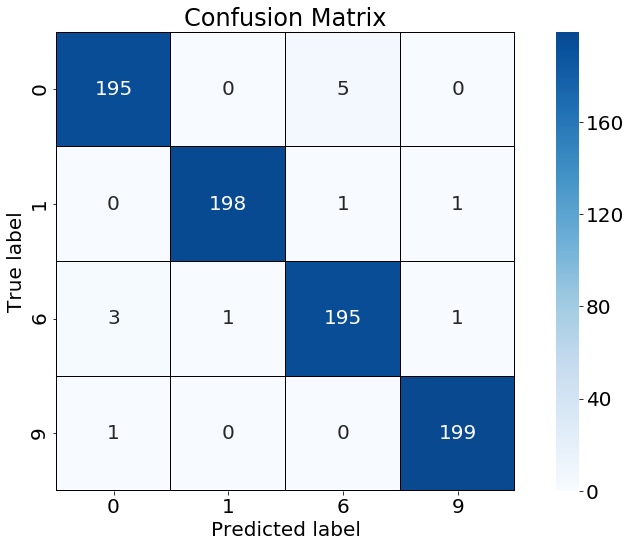

In [26]:
plt.rcParams.update({'font.size': 20})
# Plot averaged confusion matrix
df_cm = pd.DataFrame(conf_matrix, 
                     index=np.unique(y_test),
                     columns=np.unique(y_test))
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, fmt='', cmap='Blues',
            cbar=True, square=True, center=110,
            linewidths=.1, linecolor='black')
plt.ylim((4,0))
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
# plt.savefig("confusion_matrix.pdf", format="pdf")
plt.show()